0.00178599357605
0.26547908783
0.562339067459
0.00286793708801


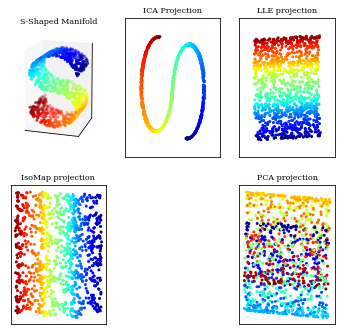

In [6]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import ticker
import time
from sklearn import manifold, datasets, decomposition


#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# generate the S-curve dataset
np.random.seed(0)

n_points = 1100
n_neighbors = 10
out_dim = 2

X, color = datasets.samples_generator.make_s_curve(n_points)

# change the proportions to emphasize the weakness of PCA
X[:, 1] -= 1
X[:, 1] *= 1.5
X[:, 2] *= 0.5

#------------------------------------------------------------
# Compute the projections
s1=time.time()
pca = decomposition.PCA(out_dim)
Y_pca = pca.fit_transform(X)
print( +time.time()-s1)
s2=time.time()
lle = manifold.LocallyLinearEmbedding(n_neighbors, out_dim, method='modified')
Y_lle = lle.fit_transform(X)
print(time.time()-s2)
s3=time.time()
iso = manifold.Isomap(n_neighbors, out_dim)
Y_iso = iso.fit_transform(X)
print(time.time()-s3)
s4=time.time()
ica = decomposition.FastICA()
Y_ica=ica.fit_transform(X)
print(time.time()-s4)
#------------------------------------------------------------
# plot the 3D dataset
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.05, right=0.95,
                    bottom=0.05, top=0.9)
try:
    # matplotlib 1.0+ has a toolkit for generating 3D plots
    from mpl_toolkits.mplot3d import Axes3D
    ax1 =fig.add_subplot(231, projection='3d',
                          xticks=[], yticks=[], zticks=[])
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=color,
                cmap=plt.cm.jet, s=9, lw=0)
    ax1.view_init(11, -73)
    ax1.set_title("S-Shaped Manifold")

except:
    # In older versions, we'll have to wing it with a 2D plot
    ax1 = fig.gcf()

    # Create a projection to mimic 3D scatter-plot
    X_proj = X / (X.max(0) - X.min(0))
    X_proj -= X_proj.mean(0)
    R = np.array([[0.5, 0.0],
                  [0.1, 0.1],
                  [0.0, 0.5]])
    R /= np.sqrt(np.sum(R ** 2, 0))
    X_proj = np.dot(X_proj, R)

    # change line width with depth
    lw = X[:, 1].copy()
    lw -= lw.min()
    lw /= lw.max()
    lw = 1 - lw

    ax1.scatter(X_proj[:, 0], X_proj[:, 1], c=color,
                cmap=plt.cm.jet, s=9, lw=lw, zorder=10)

    # draw the shaded axes
    ax1.fill([-0.7, -0.3, -0.3, -0.7, -0.7],
             [-0.7, -0.3, 0.7, 0.3, -0.7], ec='k', fc='#DDDDDD', zorder=0)
    ax1.fill([-0.3, 0.7, 0.7, -0.3, -0.3],
             [-0.3, -0.3, 0.7, 0.7, -0.3], ec='k', fc='#DDDDDD', zorder=0)
    ax1.fill([-0.7, 0.3, 0.7, -0.3, -0.7],
             [-0.7, -0.7, -0.3, -0.3, -0.7], ec='k', fc='#DDDDDD', zorder=0)

    ax1.xaxis.set_major_locator(ticker.NullLocator())
    ax1.yaxis.set_major_locator(ticker.NullLocator())

#------------------------------------------------------------
# Plot the projections
subplots = [236, 233, 234,232]
titles = ['PCA projection', 'LLE projection', 'IsoMap projection', 'ICA Projection']
Yvals = [Y_pca, Y_lle, Y_iso,Y_ica]

for (Y, title, subplot) in zip(Yvals, titles, subplots):
    ax = fig.add_subplot(subplot)
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.jet, s=9, lw=0)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()



In [3]:
lle.reconstruction_error_

1.8359095723329439e-06

In [27]:
iso.reconstruction_error()


0.10232239643219629

In [21]:
print(pca.explained_variance_ratio_)

[ 0.44223391  0.30308182]


In [47]:
ica.mixing_

array([[ -3.54842303, -23.53033339,   0.33456842],
       [ -0.18235155,   0.07186771, -29.36468315],
       [ 22.79959107,  -1.64903351,  -0.40977574]])

As we can see from the graphs, the ICA projection best captures the  data with the LLE and the IsoMap behind it in respective orders. The PCA is clearly not very good because if we try to find eigenvectors corresponding to the largest eigenvalues of such a highly non-linear data set and then linearize it, the projection will not capture the structure of the data. This is why only 44.2% and 30.3% of the data's variance is explained by the eigenvectors of the PCA. Next, the IsoMap has a reconstruction error of about 10.2% while the LLE reconstruction error is much lower, about 1.84(10^-4). This is because the IsoMap criterion is focused on preserving the distances between the data (it is an isometry of the manifold with the plane) so it does not capture the tightly clustered data as well. For example, the yellow, orange data are isometrically close to each other, so the IsoMap projection does not distinguish them well. The LLE algorithm on the other hand has very low reconstruction error precisely because manifolds are locally linear, i.e. a  in 3-space is of course locally similar to  2-space by definition. Since LLE looks locally at how the manifold behaves, and provides an approximation for that, the LLE algorithm will be good on any manifold projection. Finally, the ICA provides the canonical mathematical projection of the manifold into 2-space. This is because the ICA algorithm searches for dependences of variables on each other, but we created the data by making the different axes constant multiples of each other. Hence the ICA will provide a very good approximation of this data. Computationally, all of these methods required less than a second but it is notable that the ICA algorithm was the fastest. 


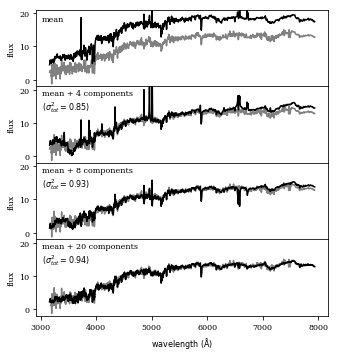

In [12]:

import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA

from astroML.datasets import sdss_corrected_spectra
from astroML.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)


#------------------------------------------------------------
# Download data
data=np.load('spec4000.npz')
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

#------------------------------------------------------------
# Compute PCA components

# Eigenvalues can be computed using PCA as in the commented code below:

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(spectra)
evals = pca.explained_variance_ratio_
evals_cs = evals.cumsum()

#  because the spectra have been reconstructed from masked values, this
#  is not exactly correct in this case: we'll use the values computed
#  in the file compute_sdss_pca.py
evals = data['evals'] ** 2
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]
evecs = data['evecs']
spec_mean = spectra.mean(0)

#------------------------------------------------------------
# Find the coefficients of a particular spectrum
spec = spectra[1]
coeff = np.dot(evecs, spec - spec_mean)

#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

for i, n in enumerate([0, 4, 8, 20]):
    ax = fig.add_subplot(411 + i)
    ax.plot(wavelengths, spec, '-', c='gray')
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-k')

    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

    ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()





Here we ran code to get the eigenvalues of the spectra. As can be seen from the spectra and the sigma value, the approximated spectra increase in accuracy as the number of used eigenvalues increases. However, the results here also confirm the results of the paper that we read this week, that the accuracy increases greatly from 4-8 eigenvalues but from 8-20 there is only a very small increase in accuracy. So it is more computationally efficient to use around 3-8 eigenvalues as suggested by the paper.